In [1]:
# ## BGG API
# https://www.boardgamegeek.com/xmlapi2/thing?id=161599&comments=1
# https://www.boardgamegeek.com/xmlapi2/hot?type=boardgame
# ## NLP WITH TF
# https://www.tensorflow.org/hub/tutorials/tf2_text_classification

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.model_selection import GridSearchCV

from IPython.display import HTML
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

from utilities import get_hot_data, get_comments, remove_short_comments, build_model, print_my_examples

print("Version:     ", tf.__version__)
print("Eager mode:  ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU:         ", "available" if tf.config.list_physical_devices('GPU') else "NOT available")

tf.get_logger().setLevel('ERROR')

Version:      2.6.0
Eager mode:   True
Hub version:  0.12.0
GPU:          available


In [3]:
# tf.debugging.set_log_device_placement(True)

In [4]:
GOOD_REVIEW_THRESHOLD = 7
VAL_FRACTION = 0.25
MIN_COMMENT_LEN = 25
TOP_N = 5
MODEL_NAME = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1"
# MORE ABOUT MODEL NAMES: 
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1"
# we also tested these solutions with dimension equals to 128 but accuracy 
# is a bit lower (0.85 for 128 vs 0.86 for 50) and training sometimes stops 
# unexpectedly for memory limit
#
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1"
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50-with-normalization/1"
# there is no difference between normalization and not so we use the one 
# without normalization

## GET DATA

In [5]:
hot_array = get_hot_data()
hot_array[:2]

[{'id': '307002',
  'rank': '1',
  'thumbnail': 'https://cf.geekdo-images.com/C9U2E51tkzLljewFEGQ74g__thumb/img/4KV3wj3NiJDgGTh3zmW0_8Ph3Zc=/fit-in/200x150/filters:strip_icc()/pic5837347.jpg',
  'name': 'Regicide',
  'yearpublished': '2020'},
 {'id': '22245',
  'rank': '2',
  'thumbnail': 'https://cf.geekdo-images.com/x4s694EfCpt7MtxAwzRDuQ__thumb/img/YeqqzGqiMeAWOGNZlWUv607i9ZY=/fit-in/200x150/filters:strip_icc()/pic5854330.jpg',
  'name': 'Royal Visit',
  'yearpublished': '2006'}]

In [6]:
def get_game_by_id(game_id, field='name'):
    for a in hot_array:
        if a['id'] == str(game_id):
            return a[field]

In [7]:
try:
    comments_df = pd.read_csv(f"comments_{datetime.now().strftime('%Y%m%d')}.csv")
    comments_df['rating'] = comments_df.rating.fillna('N/A')
    print("reading dataframe from csv file...")
except:
    print("missing csv file, getting new data using API...")
    comments_df = get_comments(hot_array, verbose=10)
    comments_df.to_csv(f"comments_{datetime.now().strftime('%Y%m%d')}.csv", index=False)
comments_df

missing csv file, getting new data using API...
page number = 10 (max: 100, len: 29)
page number = 20 (max: 100, len: 24)
page number = 30 (max: 100, len: 18)
page number = 40 (max: 100, len: 13)
page number = 50 (max: 100, len: 10)
page number = 60 (max: 100, len: 7)
page number = 70 (max: 100, len: 6)
page number = 80 (max: 100, len: 5)
page number = 90 (max: 100, len: 3)
page number = 100 (max: 100, len: 1)
comments_df shape: (130878, 4)


,id,username,rating,value
0,307002,AgentMeat,2,"only solo, played with normal deck of cards, s..."
1,307002,Akuden,8,Kickstarted. Tried out the game solo and at 2 ...
2,307002,amqueue,N/A,kickstarter
3,307002,andrewkapish,N/A,Unplayed
4,307002,Angelo the Magician,9,I only play the solo version and that one is ...
...,...,...,...,...
130873,167791,z_zadar,9,Some games are so much fun. Others can be a li...
130874,167791,_Czid_,8,Have played with Elysium and Prelude expansion...
130875,167791,_Marty_,9.5,Fantastic game. With so many cards that can ch...
130876,167791,_mun_,10,"Nagyon izgalmas játék, jó a mechanizmusa. A sz..."


## DATA CLEANING

In [8]:
# probably we should keep all the ratings (no matters the len) and remove only the simple comments under a certain len  
comments_df["value"] = comments_df["value"].astype(str)

In [9]:
# REMOVE URLs FROM COMMENTS
comments_df['value'] = [re.sub(r"http\S+", "", v) for v in comments_df.value.values]
comments_df = remove_short_comments(comments_df, MIN_COMMENT_LEN)

removed 20630 for 'remove_short_comments' - min len: 25 - method: unrated


In [10]:
# REMOVE NON ENGLISH COMMENTS
# !conda install -c conda-forge langdetect
# def add_comments_lang(df: pd.DataFrame):
#     df_local = df.copy()
#     df_local['lang'] = df['value'].apply(detect)
#     return df_local.reset_index(drop=True)
# comments_df = add_comments_lang(comments_df)
# comments_df = comments_df.query('lang == "en"')

## SPLIT RATED AND NON-RATED COMMENTS

In [11]:
# count number of comments per rating (N/A included)
comments_df.rating.value_counts()

9          20420
8          19128
10         18727
7          10536
N/A         8295
           ...  
2.02           1
8.24           1
3.03333        1
6.34           1
9.125          1
Name: rating, Length: 627, dtype: int64

In [12]:
# get rated comments only
rated_comments = comments_df.query('rating != "N/A"')
rated_comments.shape

(101953, 5)

In [13]:
# get non rated comments only
not_rated_comments = comments_df.query('rating == "N/A"').reset_index(drop=True)
not_rated_comments.shape

(8295, 5)

## CREATE TRAINING AND VALIDATION DATA

In [14]:
# use rated comments (reviews) to train the model

In [15]:
rated_comments = rated_comments.sample(frac=1)

In [16]:
# create training X and y
train_examples = list(rated_comments.value)
train_labels = list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int))

In [17]:
print("example of positive rating:")
train_examples[train_labels.index(1)]

example of positive rating:


'amazing game both cooperative as well as solo'

In [18]:
print("example of negative rating:")
train_examples[train_labels.index(0)]

example of negative rating:


"I have only played this solo as I cannot convince anyone to play with me. I love the components, the art is great. I WANT to like it, I just haven't enjoyed it as a solo."

## COMPOSE MODEL

In [19]:
hub_layer = hub.KerasLayer(MODEL_NAME, input_shape=[], dtype=tf.string, trainable=True)

## CLASSIFIER

In [20]:
def build_classifier():
    return build_model(hub_layer=None, pre_trained_model_name=MODEL_NAME, model_type='classifier', verbose=0)


estimator = KerasClassifier(build_fn=build_classifier, epochs=100, batch_size=1024, verbose=2, validation_split=VAL_FRACTION)
x_train_clf = np.array(list(rated_comments.value))
y_train_clf = np.array(list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int)))

clf = GridSearchCV(
    estimator, 
    cv=3, 
    param_grid={}
)
clf.fit(x_train_clf, y_train_clf, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.001)])

Epoch 1/100
50/50 - 5s - loss: 0.6080 - accuracy: 0.7153 - val_loss: 0.5309 - val_accuracy: 0.8343
Epoch 2/100
50/50 - 3s - loss: 0.4874 - accuracy: 0.8463 - val_loss: 0.4521 - val_accuracy: 0.8505
Epoch 3/100
50/50 - 3s - loss: 0.4017 - accuracy: 0.8521 - val_loss: 0.3804 - val_accuracy: 0.8530
Epoch 4/100
50/50 - 3s - loss: 0.3367 - accuracy: 0.8645 - val_loss: 0.3437 - val_accuracy: 0.8678
Epoch 5/100
50/50 - 3s - loss: 0.2942 - accuracy: 0.8865 - val_loss: 0.3252 - val_accuracy: 0.8729
Epoch 6/100
50/50 - 3s - loss: 0.2631 - accuracy: 0.8987 - val_loss: 0.3192 - val_accuracy: 0.8717
Epoch 7/100
50/50 - 3s - loss: 0.2390 - accuracy: 0.9090 - val_loss: 0.3219 - val_accuracy: 0.8727
Epoch 8/100
50/50 - 3s - loss: 0.2184 - accuracy: 0.9179 - val_loss: 0.3282 - val_accuracy: 0.8699
Epoch 9/100
50/50 - 3s - loss: 0.2013 - accuracy: 0.9252 - val_loss: 0.3381 - val_accuracy: 0.8655
Epoch 10/100
50/50 - 3s - loss: 0.1865 - accuracy: 0.9309 - val_loss: 0.3518 - val_accuracy: 0.8642
34/34 - 0

GridSearchCV(cv=3,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x00000159878E2EE0>,
             param_grid={})

In [21]:
classifier = clf.best_estimator_
classifier_history_dict = classifier.model.history.history

In [22]:
classifier_history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [23]:
acc = classifier_history_dict['accuracy']
val_acc = classifier_history_dict['val_accuracy']
loss = classifier_history_dict['loss']
val_loss = classifier_history_dict['val_loss']

In [24]:
epochs = range(1, len(acc) + 1) 

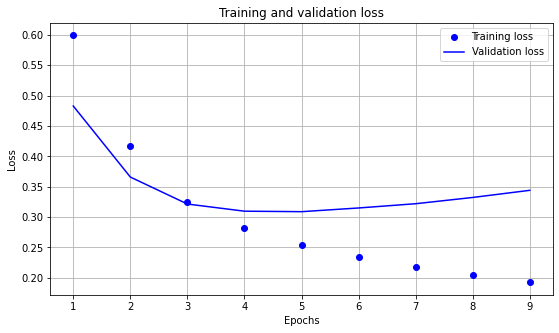

In [25]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

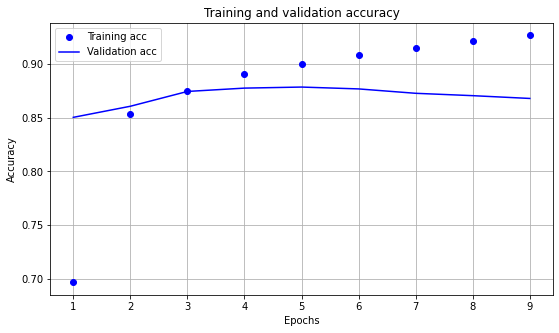

In [26]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.show()

In [27]:
inputs = x_train_clf[:10]
outputs = y_train_clf[:10]
results = classifier.predict(tf.constant(inputs), verbose=0)
print_my_examples(inputs, results, outputs)

input:
"amazing game both cooperative as well as solo"
score: 1.000000
actual: 1

input:
"I have only played this solo as I cannot convince anyone to play with me. I love the components, the art is great. I WANT to like it, I just haven't enjoyed it as a solo."
score: 1.000000
actual: 0

input:
"A magnum opus of a game. Looks mighty impressive when set up. Looks like I haven't logged any plays but I've played at least 4 times. A bit of a bear to set up which means this is a special occasion type of game. Amazing. "
score: 1.000000
actual: 1

input:
"Combos de cartas rapidísimo. La app para calcular la puntuación va de lujo."
score: 1.000000
actual: 1

input:
"Juego cooperativo en el que tienes que planificar muy bien las acciones para conseguir sobrevivir, la sensación de agobio es continua durante toda la partida.  El juego consigue mantenerte en la cuerda floja entre el éxito y el fracaso permanentemente."
score: 1.000000
actual: 1

input:
"Nice engine builder with cool critical mass

In [28]:
## APPLY MODEL ON NON-RATED COMMENTS

In [29]:
not_rated_comments = not_rated_comments.sample(frac=1)
results = classifier.predict(tf.constant(list(not_rated_comments.value.astype(str))))
print_my_examples(list(not_rated_comments.value), results, limit=10)

input:
"No gaming group for this monster - so got to sold it =(("
score: 0.000000

input:
"Birthday present. Karsten og Marianne + Jan og Julie"
score: 1.000000

input:
"Kickstarter Collector's  édition French version"
score: 1.000000

input:
"Better liked by my household than by me."
score: 0.000000

input:
"+ Lords of Middle-earth + Warriors of Middle-Earth"
score: 1.000000

input:
"This looks like a fascinating game but not one I’d ever play. "
score: 1.000000

input:
"Sundropped, fully painted heroes"
score: 1.000000

input:
"Concordia is good because it is fairly easy and at the same time with a lot of depht. However there are also downsides. There is no round-limit meaning that the game can potentially drag out. The theme is not as thorough as it could be. Spreading power and Roman culture through commerce makes sense but considering that military power was also a significant tool for ancient Rome, I can't help something is severely lacking in this game. Player interaction is als

## REGRESSOR

In [30]:
def build_regressor():
    return build_model(hub_layer, pre_trained_model_name=MODEL_NAME, model_type='regressor', verbose=0)


estimator = KerasRegressor(build_fn=build_regressor, epochs=100, batch_size=512, verbose=0, validation_split=VAL_FRACTION)
x_train_reg = np.array(list(rated_comments.value))
y_train_reg = np.array(list(rated_comments.rating.astype(float)))

clf = GridSearchCV(
    estimator, 
    cv=3, 
    param_grid={}
)
clf.fit(x_train_reg, y_train_reg, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=5, min_delta=0.001)])

GridSearchCV(cv=3,
             estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x0000015D04951370>,
             param_grid={})

In [31]:
regressor = clf.best_estimator_
regressor_history_dict = regressor.model.history.history

In [32]:
regressor_history_dict.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])

In [33]:
mean_squared_error = regressor_history_dict['mean_squared_error']
val_mean_squared_error = regressor_history_dict['val_mean_squared_error']
loss = regressor_history_dict['loss']
val_loss = regressor_history_dict['val_loss']

In [34]:
epochs = range(1, len(mean_squared_error) + 1) 

In [35]:
print(f"MEAN SQUARED ERROR (VALIDATION SET): {val_mean_squared_error[-1]:.2f}")

MEAN SQUARED ERROR (VALIDATION SET): 2.22


In [36]:
print(f"MEAN SQUARED ERROR (TRAINING SET): {mean_squared_error[-1]:.2f}")

MEAN SQUARED ERROR (TRAINING SET): 1.00


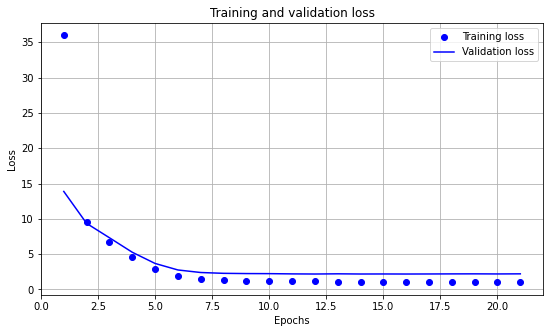

In [37]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

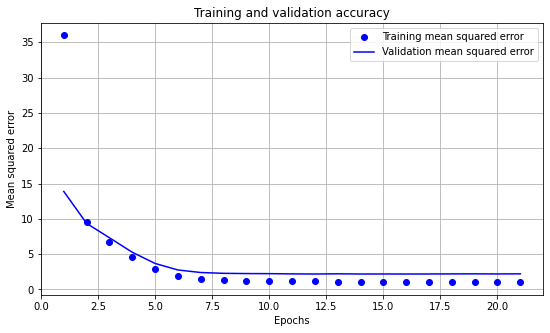

In [38]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, mean_squared_error, 'bo', label='Training mean squared error')
plt.plot(epochs, val_mean_squared_error, 'b', label='Validation mean squared error')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Mean squared error')
plt.grid(True)
plt.legend()

plt.show()

In [39]:
inputs = x_train_reg[:10]
outputs = y_train_reg[:10]
results = clf.best_estimator_.predict(tf.constant(inputs), verbose=0)
for i in range(len(inputs)):
    print(f"input: \n\"{inputs[i]}\"\nscore: {results[i]:.2f}\nactual: {outputs[i]:.2f} \n")

input: 
"amazing game both cooperative as well as solo"
score: 9.38
actual: 8.00 

input: 
"I have only played this solo as I cannot convince anyone to play with me. I love the components, the art is great. I WANT to like it, I just haven't enjoyed it as a solo."
score: 7.66
actual: 6.50 

input: 
"A magnum opus of a game. Looks mighty impressive when set up. Looks like I haven't logged any plays but I've played at least 4 times. A bit of a bear to set up which means this is a special occasion type of game. Amazing. "
score: 8.02
actual: 9.10 

input: 
"Combos de cartas rapidísimo. La app para calcular la puntuación va de lujo."
score: 7.81
actual: 7.00 

input: 
"Juego cooperativo en el que tienes que planificar muy bien las acciones para conseguir sobrevivir, la sensación de agobio es continua durante toda la partida.  El juego consigue mantenerte en la cuerda floja entre el éxito y el fracaso permanentemente."
score: 8.70
actual: 9.00 

input: 
"Nice engine builder with cool critica

## COMPARE CLASSIFIER VS REGRESSOR

In [40]:
not_rated_comments = not_rated_comments.sample(frac=1)
inputs = list(not_rated_comments.value.astype(str))[:10]

clf_results = classifier.predict(inputs, verbose=0)
reg_results = regressor.predict(inputs, verbose=0)
for i in range(len(inputs)):
    print(f"""\"{inputs[i]}\"
    reg score: {reg_results[i]:.2f}
    clf score: {clf_results[i][0]}
""")

"Includes folded space insert and realistic resources "
    reg score: 8.70
    clf score: 1

"Finally a game that sees colonization as a blight or crime rather than noble venture. Unfortunately this is a busy/complicated combat game.  The release is delayed until March 2017."
    reg score: 5.84
    clf score: 0

"Includes Invaders from Afar and wooden insert"
    reg score: 8.77
    clf score: 1

"I actually have the 2019 edition of this game with the extra expansions. I have not played it enough to rate it yet."
    reg score: 8.63
    clf score: 1

"Punched counters. Never played.  Smoke free home.  All of my games are treated very well."
    reg score: 9.25
    clf score: 1

"Anniversary Release  all figures hand-painted  larger game boards  counters and cards same as 2nd Edition A numbered certificate of authenticity included"
    reg score: 6.52
    clf score: 1

"Kickstarter Edition. Got in trade for King's Dilemma and Planet X"
    reg score: 7.96
    clf score: 1

"Recommende

### RESULTS
It seems that the regressor is much more accurate compared to the binary classifier => **let's use the regressors results to fix the BGG rating**

## COMBINE RATED COMMENTS AND NOT-RATED COMMENTS WITH PREDICTED RATING

In [41]:
rated_comments['rating'] = rated_comments.rating.astype(float)
rated_comments_grouped = rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
rated_comments_grouped.columns = list(rated_comments_grouped.columns.map('_'.join))
rated_comments_grouped = rated_comments_grouped.reset_index()
print("rated_comments_grouped: ")
print(rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

rated_comments_grouped: 
|     id |   rating_mean |   rating_count |
|--------|---------------|----------------|
| 115746 |          8.73 |           1949 |
| 121921 |          7.74 |           4527 |
| 124361 |          8.18 |           3980 |
| 162886 |          8.37 |           3731 |
| 167355 |          8.41 |           2034 |


In [42]:
not_rated_comments['rating'] = regressor.predict(list(not_rated_comments.value.astype(str)))

In [43]:
not_rated_comments['rating'] = not_rated_comments.rating.astype(float)
not_rated_comments['rating'] = not_rated_comments['rating'].clip(0, 10)
not_rated_comments_grouped = not_rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
not_rated_comments_grouped.columns = list(not_rated_comments_grouped.columns.map('_'.join))
not_rated_comments_grouped = not_rated_comments_grouped.reset_index()
print("not_rated_comments_grouped: ")
print(not_rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

not_rated_comments_grouped: 
|     id |   rating_mean |   rating_count |
|--------|---------------|----------------|
| 115746 |          8.27 |            267 |
| 121921 |          8.04 |            464 |
| 124361 |          8.12 |            259 |
| 162886 |          8.09 |            329 |
| 167355 |          8.29 |            213 |


In [44]:
grouped = rated_comments_grouped.merge(not_rated_comments_grouped, on='id', suffixes=('_review', '_comments'), how='outer')
grouped['id'] = grouped.id.astype(str)
grouped = grouped.merge(pd.DataFrame(hot_array), on='id', how='right')
grouped['rank'] = grouped['rank'].astype(int)
grouped['url'] = grouped['id'].apply(lambda x: f"https://boardgamegeek.com/boardgame/{x}")
grouped['fixed_rating'] = (grouped['rating_mean_review']*grouped['rating_count_review']+grouped['rating_mean_comments']*grouped['rating_count_comments']) /\
                            (grouped['rating_count_review']+grouped['rating_count_comments'])
grouped['thumbnail'] = grouped['thumbnail'].apply(lambda x: f'<img src="{x}" width="124" />')
grouped['name'] = grouped.apply(lambda x: f'<a href="{x["url"]}">{x["name"]}</a>', axis=1)

grouped = grouped[['thumbnail', 'name', 'rating_mean_review', 'rating_mean_comments', 'fixed_rating', 'rank', 'yearpublished']]

In [45]:
grouped.head()

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
0,"<img src=""https://cf.geekdo-images.com/C9U2E51...","<a href=""https://boardgamegeek.com/boardgame/3...",7.876958,8.081381,7.892683,1,2020
1,"<img src=""https://cf.geekdo-images.com/x4s694E...","<a href=""https://boardgamegeek.com/boardgame/2...",6.480789,6.553968,6.486430,2,2006
2,"<img src=""https://cf.geekdo-images.com/_al0scM...","<a href=""https://boardgamegeek.com/boardgame/2...",7.538033,8.057503,7.660165,3,2021
3,"<img src=""https://cf.geekdo-images.com/Bo-JkTT...","<a href=""https://boardgamegeek.com/boardgame/2...",8.000000,6.815590,7.506496,4,2021
4,"<img src=""https://cf.geekdo-images.com/Q96PxRV...","<a href=""https://boardgamegeek.com/boardgame/3...",7.198911,7.201793,7.199075,5,2021


In [46]:
def display_topn(by, n=5, ascending=True):
    temp_df = grouped.sort_values(by, ascending=ascending).head(n)
    temp_df.index=list(range(1, n+1))
    return HTML(temp_df.to_html(escape=False, classes='table table-striped'))

In [47]:
# TOP N RANK
display_topn(by='rank', n=TOP_N)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Regicide,7.876958,8.081381,7.892683,1,2020
2,,Royal Visit,6.480789,6.553968,6.486430,2,2006
3,,Ankh: Gods of Egypt,7.538033,8.057503,7.660165,3,2021
4,,Khôra: Rise of an Empire,8.000000,6.815590,7.506496,4,2021
5,,Descent: Legends of the Dark,7.198911,7.201793,7.199075,5,2021


In [48]:
# TOP N REVIEW RANK
display_topn(by='rating_mean_review', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Voidfall,10.000000,7.703174,8.056532,12,2022
2,,Agemonia,9.400000,7.715696,9.107078,9,2022
3,,Black Rose Wars: Rebirth,8.833333,9.173317,8.987871,38,2022
4,,Eclipse: Second Dawn for the Galaxy,8.734049,8.034946,8.630825,36,2020
5,,War of the Ring: Second Edition,8.730555,8.274619,8.675620,43,2012


In [49]:
# TOP N FIXED RANK
display_topn(by='fixed_rating', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Agemonia,9.400000,7.715696,9.107078,9,2022
2,,Black Rose Wars: Rebirth,8.833333,9.173317,8.987871,38,2022
3,,War of the Ring: Second Edition,8.730555,8.274619,8.675620,43,2012
4,,Brass: Birmingham,8.675656,8.168922,8.631036,21,2018
5,,Eclipse: Second Dawn for the Galaxy,8.734049,8.034946,8.630825,36,2020


In [50]:
# model.save('saved_model\my_model')

In [51]:
# saved_model = tf.keras.models.load_model('saved_model\my_model')

In [52]:
# some examples on "long" comments vs short comments

In [53]:
not_rated_comments['comment_len'] = not_rated_comments['value'].str.len()
some_long_comments = not_rated_comments.query("comment_len>100 and comment_len<300").sample(frac=1).head(25).sort_values('rating')

In [54]:
some_long_comments.apply(lambda c: print(f"\"{c['value']}\" ({get_game_by_id(c['id'])}) \nscore: {c['rating']:.2f}\n"), axis=1);

"I see why people like it. The event system is clever and it does make for interesting stories. But, it just didn't click with me. I just don't like the dice'" (Robinson Crusoe: Adventures on the Cursed Island) 
score: 5.25

"Holding off on rating this as I've only played an outdated development kit version of this. That one play did excite me though! Where Root was an approachable version of a COIN game, this seems to do the same for Pax games." (Oath: Chronicles of Empire and Exile) 
score: 5.56

"Kinda meh actually. It's really good looking, but I find the game pretty bland, as if it's too simple and friendly. I've felt the same about Stegmaier's other games." (Scythe) 
score: 6.43

"Played once, didn't want to play again. As far as I could tell (and maybe I'm missing out on something!) you play the best card you have, and hope for the best. Over. And. Over. And. Over. This lead to a very dull back-and-forth play experience." (Royal Visit) 
score: 6.48

"Varied, multiple endings for

## RANDOM FOREST - TEST

In [55]:
# no support for Windows at the moment - waiting for it to test